# Using a Physics Informed Neural Network (PINN) to solve the Blasius equation

Objective of this project is to compare different methods to solve numerically the Blausius equation, for which an analytical solution is still not known.

More in detail, we will compare a standard method for the numerical computation of the solution, given by the *solve_bvp* algorithm of SciPy, to two different implementations of a Physically Informed Neural Network (PINN) [2, 3, 4]:
- the first one implementing an unsupervised learning process,
- the second one implementing a supervised learning process

PINNs are a particular class of neural networks whose study has recently begun, and which are having a lot of success. They have been developped starting from the observation that neural networks are proving to be very effective in solving problems of applied mathematics such as Partial Differential Equations (PDEs).
Aim of this class of algorithms is to compute numerical solutions for differential equations in a more efficient way that standard computational methods. The way they achive this is by exploiting the knowledge of the equation to improve the training of the network (more details on this are provided later in the project)

## Theoretical introduction

### Blausius equation

The *Blasius equation*

\begin{equation}
  f^{'''} + \frac{1}{2} f f^{''} = 0
\end{equation}

is a simplification of the Navier-Stokes equation that describes the steady two-dimensional laminar boundary layer that forms on a semi-infinite plate which is held parallel to a constant unidirectional flow.
The boundary conditions here considered are the ones proposed by Blasius which account for the no-slip condition

\begin{equation}
  \begin{cases}
    &f(0) = 0\\
    &f^{'}(0) = 0\\
    &\lim_{x \to \infty} f^{'}(x) = 1
  \end{cases}.
\end{equation}

Since we are dealing with a computational task, the last condition ($f^{'}(\infty)$) will be intended as: the derivative $f^{'}$ evaluated at a sufficiently large number is equal to 1 [1]

#### On the differential equation

The Blasius equation is a nonlinear, boundary value problem (BVP) for the third order differential equation [1]

We observe that this equation admits both Dirichlet ($f(0) = 0$) and Robin ($f^{'}(0) = 0, f^{'}(\infty) = 1$) boundary conditions



At the moment an exact analytical solution for this equation is not know. Therefore, the only way to solve it is via numerical methods

### Physically Informed Neural Networks (PINNs)

This class of Neural Networks was developed specifically for solving differential equations numerically. PINNs are deep-learning networks that, given an input point in the integration domain, produce an estimate solution in that point of a differential equation after training [4]

What sets apart PINNs from other methods is that they take into account the underlying differential equation, i.e. the physics of the problem, during training, rather than attempting to deduce the solution based solely on data. This is achieved by defining a custom loss function for the neural network that includes knowledge about the equation under study [4]




#### The physically informed loss function

The loss function used by PINNs is defined as

\begin{equation}
  L(\theta) = \omega_{F} L_{F}(\theta) + \omega_{B} L_{B}(\theta) + \omega_{D} L_{D}(\theta),
\end{equation}

where:
- $\theta$ is the parameter with respect to which we want to minimize,
- $L_{F}$ is the part of the loss function calculated with respect to the residual of the differential equation
- $L_{B}$ is the part of the loss function calculated taking into consideration the boundary conditions,
- $L_{D}$ is the part of the loss function calculated taking into consideration any known data of the problem under consideration and,
- $\omega_{F}$, $\omega_{B}$, $\omega_{D}$ are appropriate weights [4]

Given this new loss function, then, the resulting optimization problem can be handled using the normal stochastic gradient descent algorithm (this is the case for this project)

Referring to the cases studied in this project, $L_{D}$ appears in the loss function of the supervised learning case, while it is absent in the unsupervised one

#### Setting of the problem


Expressing the differential equation as

\begin{align}
  F\left( u(z)); \gamma \right) & = f(z) \quad z \in \Omega\\
  B\left( u(z)\right) & = g(z) \quad z \in \partial \Omega
\end{align}

defined on the domain $\Omega \subset R^{d}$ with boundary $\partial \Omega$. Where $z := [x_{1}, \dots, x_{d-1}; t]$ indicates the space-time coordinate vector, $u$ represents the unknown solution, $\gamma$ are the parameters related to the physics, $f$ is the function identifying the data of the problem, $F$ is the non linear differential operator. Finally, since the initial condition can actually be considered as a type of Dirichlet boundary condition on the spatio-temporal domain, it is possible to denote $B$ as the operator indicating arbitrary initial or boundary conditions related to the problem and $g$ the boundary function. Indeed, the boundary conditions can be Dirichlet, Neumann, Robin, or periodic boundary conditions [4]

Objective of PINNs is to approximate the solution

\begin{equation}
  u_{\theta}(z) \approx u(z),
\end{equation}

where the approximation depends on a series of parameters $\theta$ on which we optimize the network.



##### Explicit form of the loss function

Having defined the setup, we can then explicitly calculate the loss functions. A typical implementation uses the mean square error formulation:

\begin{equation}
  \begin{aligned}
    &L_{F}(\theta) = MSE_{F} = \frac{1}{N_{c}} \sum_{i = 1}^{N_{c}} || F(u_{\theta}(z_i)) - f(z_i) ||^{2}\\
    &L_{B}(\theta) = MSE_{B} = \frac{1}{N_{B}} \sum_{i = 1}^{N_{B}} || B(u_{\theta}(z_i)) - g(z_i) ||^{2}\\
    &L_{D}(\theta) = MSE_{D} = \frac{1}{N_{d}} \sum_{i = 1}^{N_{d}} || u_{\theta}(z_i) - u^*_i ||^{2}\\
  \end{aligned},
\end{equation}

where $z_i$ is the i-th input passed to the network within a training batch and $u^*_i$ is the empirically known solution corresponding to the input $z_i$ [4]

#### PINNs' architectures


PINNs allow for the implementation of a wide variety of architectures. A summary on the topic can be found in Ref. [4]


In the particular case under study a fully connected deep neural network is sufficient

In particular, in both cases we will adopt a fully connected neural network with input and output of dimension one and 2 hidden layers containing 20 neurons each

##### Activation function

Regarding the activation function used in the hidden layers' neurons, the one that is mostly used in the literature of PINN is *tanh* [4]

For this reason this activation function will also be the one we will use

Since we want a real number as outuput of the network, we will not apply any activation function on the neuron composing the output layer

## Finding the numerical solution using SciPy

We begin by finding the solution to the equation using a numerical method. In particular, we will use the *solve_bvp* function from the SciPy library. This is a numerical solver for boundary value problems



**NOTE**: The procedure here implemented was adapted from the one proposed in Ref. [5]

### Mathematical Fundations

Before implementing the algorithm we have to make some further mathematical considerations regarding the Blasius equation that are needed for the implementation of the solve_bvp algorithm

#### Transforming the third order equation into a system of first order differential equations

The solver algorithm implemented by the function solve_bvp requires the differential equation to be expressed as a system of first order differential equations

The system of first order differential equations equivalent to

\begin{equation}
  f^{'''} + \frac{1}{2}f f^{''} = 0
\end{equation}

is given by

\begin{cases}
  &f^{'}_{1} = f_{2}\\
  &f^{'}_{2} = f_{3}\\
  &f^{'}_{3} = -\frac{1}{2}f_{1}f_{3}
\end{cases}

with the boundary conditions that now become

\begin{cases}
  &f_{1}(0) = 0\\
  &f_{2}(0) = 0\\
  &f_{2}(\infty) = 1
\end{cases}

where, as already discussed above, with $f_{2}(\infty) = 1$ we indentend the function $f_{2}$ evaluated at a sufficiently large number

#### Initial guess

The algorithm also requires an initial guess for the solution

The initial guess we have chosen to use is

\begin{equation}
  \begin{cases}
      &f_1 = e^{-x} + x -1\\
      &f_2 = f^{'}_{1} = - e^{-x} + 1\\
      &f_{3} = f^{'}_{2} = e^{-x}
  \end{cases}
\end{equation}

Obviously this tentative solution does not solve the differential equation under study. For the algorithm to work it is sufficient that it approximates the trend of the solution described by the known data, in this case the boundary conditions. It is, in fact, possible to verify that our tentative solution satisfies these latter conditions

### Code implementation

#### Importing the libraries

In [1]:
#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt

#Importing the solver
from scipy.integrate import solve_bvp

#For comparing the execution times of the different methods
from time import time

#### Setting the parameters

We set the seed for the random generator for reproducibility of the results

In [2]:
np.random.seed(1234)

We will study the problem on the segment [0,5] and solve the problem over 100000 points uniformly distributed over that segment



In [3]:
xmin = 0
xmax = 5
numPoints = 100000

In [4]:
eta = np.linspace(xmin, xmax, numPoints)

#### Defining the differential equation and the boundary conditions

As a first step one one needs to code the differential equation and its boundary conditions

In [5]:
#Implementation of the Ordinary Differential Equation (ODE)
def ode(x, f):
  #x is the variable of the function and it is the array of point on which we want the solver to determine the value of the function
  #f will be an array containing the three functions of the system of differential equations
  f1, f2, f3 = f
  df1dx = f2
  df2dx = f3
  df3dx = -0.5*f1*f3
  return [df1dx, df2dx, df3dx]

In [6]:
#For the boundary condition we have to define another function
def bc(bl, br):
  #bl is an array containing the value of the three functions f_1, f_2, f_3 at on the first boundary point (x = 0)
  #analogously for br in the case of the second boundary point (x = 5)
  f1bl, f2bl, f3bl = bl
  f1br, f2br, f3br = br
  return [f1bl, f2bl, f2br-1] #we then have to return the residual of the boundary conditions

#### Tentative solution

One then has to implement the tentative solution

In [7]:
def fGuess(x):
  f1Guess = np.exp(-x) + x - 1
  f2Guess = - np.exp(-x) + 1
  f3Guess = np.exp(-x)
  return [f1Guess, f2Guess, f3Guess]

#### Executing the numerical solver

With everything set up, one can now execute the solver


In [8]:
tInit = time()
numericalSolution = solve_bvp(ode, bc, eta, fGuess(eta), max_nodes=numPoints)
tNumericalSolver = time()-tInit

#Print computation time
print('\nComputation time for numerical solver: {} seconds'.format(tNumericalSolver))

numericalSolution


Computation time for numerical solver: 2.0078940391540527 seconds


       message: The algorithm converged to the desired accuracy.
       success: True
        status: 0
             x: [ 0.000e+00  5.000e-05 ...  5.000e+00  5.000e+00]
           sol: <scipy.interpolate._interpolate.PPoly object at 0x7ce85cf71c60>
             p: None
             y: [[-4.337e-30  4.202e-10 ...  3.317e+00  3.317e+00]
                 [ 4.401e-19  1.681e-05 ...  1.000e+00  1.000e+00]
                 [ 3.362e-01  3.362e-01 ...  1.555e-02  1.555e-02]]
            yp: [[ 4.401e-19  1.681e-05 ...  1.000e+00  1.000e+00]
                 [ 3.362e-01  3.362e-01 ...  1.555e-02  1.555e-02]
                 [ 7.289e-31 -7.063e-11 ... -2.580e-02 -2.580e-02]]
 rms_residuals: [ 2.494e-13  5.296e-13 ...  2.608e-05  2.608e-05]
         niter: 1

### Plotting the results

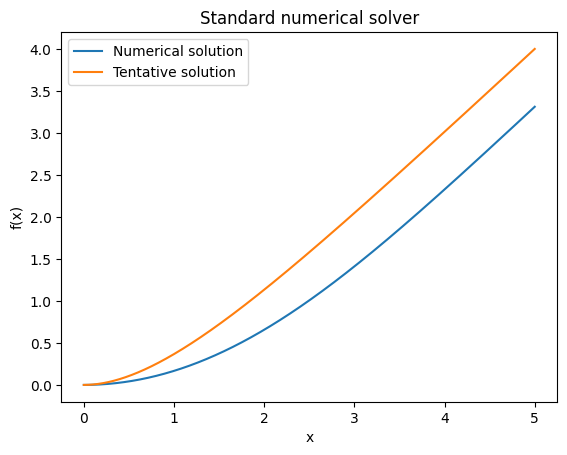

In [9]:
plt.title('Standard numerical solver')
plt.plot(numericalSolution.x, numericalSolution.y[0],label='Numerical solution')
plt.plot(eta, fGuess(eta)[0], label='Tentative solution')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

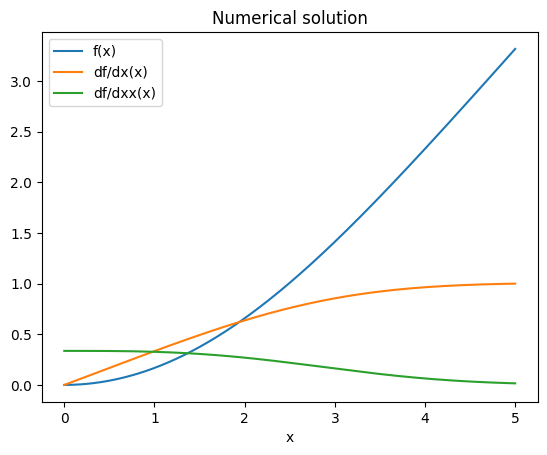

In [10]:
plt.title('Numerical solution')
plt.plot(numericalSolution.x, numericalSolution.y[0],label='f(x)')
plt.plot(numericalSolution.x, numericalSolution.y[1],label='df/dx(x)')
plt.plot(numericalSolution.x, numericalSolution.y[2],label='df/dxx(x)')
plt.xlabel('x')
plt.legend()

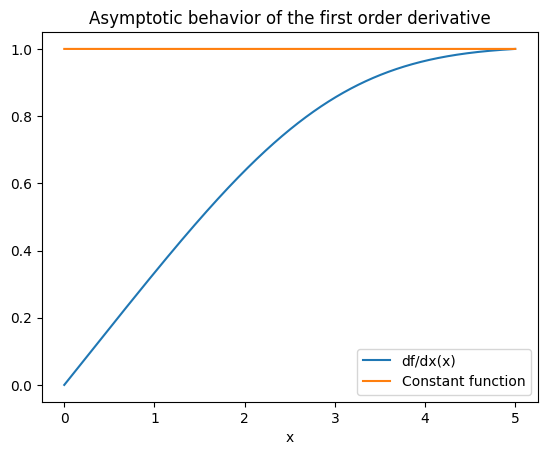

In [11]:
plt.title('Asymptotic behavior of the first order derivative')
plt.plot(numericalSolution.x, numericalSolution.y[1],label='df/dx(x)')
plt.plot(eta,np.ones(eta.size), label='Constant function')
plt.xlabel('x')
plt.legend()

**NOTE**: The numerical solution found in this way will be used for the supervised training of the PINN later in the project

## Finding the numerical solution using PINNs

### Implementation from scratch of the algorithm (Unsupervised)

We will start by implementin the PINN in the unsupervised case, meaning that in the loss function we will consider only the terms related to the residual of the differential equation and the boundary conditions. Substantially, we are supposing that we do not have any empirical data that could help training the network

**NOTE**: For the following implementation, reference was made to Refs. [2, 3, 4, 6, 7, 8, 9]

#### Importing the libraries

In [12]:
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense
from sklearn.model_selection import train_test_split

#### Defining useful functions

In [13]:
#Function for the calcualtion of the mean square error
def meanSquareError(x,y):
  return tf.reduce_mean(tf.square(x - y))

In [14]:
#Function for the calculation of the coefficient of determination, R^2
def R2(yModel, yCorr):
  return (1 - (tf.reduce_sum(tf.square(yModel - yCorr)) / tf.reduce_sum(tf.square(yModel - (tf.reduce_mean(yModel)))))).numpy()

#### Setting the parameters

The parameters are the same as in the case of the numerical solver from the library SciPy. Therefore, we just need to set the random seed also for TensorFlow

In [15]:
tf.random.set_seed(1234)

and specify the type of floats we want to work with

In [16]:
# Set data type
DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)

#### Building the network

In [17]:
networkUnsupervised = Sequential()
networkUnsupervised.add(Dense(20, input_shape=(1,), activation="tanh", kernel_initializer='glorot_normal'))
networkUnsupervised.add(Dense(20, activation="tanh", kernel_initializer='glorot_normal'))
networkUnsupervised.add(Dense(1))

networkUnsupervised.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                40        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


#### Definition of the routines to determine loss and gradient


In [18]:
#Residual of the differential equation
def residual(f, dfdx, dfdxx, dfdxxx):
  return dfdxxx + (0.5*f*dfdxx)

In [19]:
#Function to calculate the derivatives of the model
def derivativeCalculation(model, x):
    #The function tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
      #The variable x is watched during tape to compute the derivative dfdx
      tape.watch(x)

      # Determine residual
      f = model(x)

      # Compute following derivatives
      dfdx = tape.gradient(f, x)
      dfdxx = tape.gradient(dfdx, x)
      dfdxxx = tape.gradient(dfdxx, x)

      del tape

    return [f, dfdx, dfdxx, dfdxxx]

In [20]:
#Function to calculate the residual of the model
def residualCalculation(model, x):
    f, dfdx, dfdxx, dfdxxx = derivativeCalculation(model, x)
    return residual(f, dfdx, dfdxx, dfdxxx)

One has now all the elements to calculate the custom loss function used in PINNs

As already mentioned in this case we will consider only the error deriving from the residual of the differential equation and the one related to the boundary conditions

In [21]:
def computeLossUnsupervised(model, x, xmin, xmax):
  bl1 = tf.zeros(x.shape, dtype=DTYPE)
  bl2 = tf.zeros(x.shape, dtype=DTYPE)
  br = tf.ones(x.shape, dtype=DTYPE)

  xminVec = tf.zeros(x.shape, dtype=DTYPE)+xmin
  xmaxVec = tf.zeros(x.shape, dtype=DTYPE)+xmax

  leftBoundary = derivativeCalculation(model,xminVec) #Value of the model on the left boundary
  rightBoundary = derivativeCalculation(model,xmaxVec) #Value of the model on the right boundary

  #Loss with respect to the residual of the differential equation
  loss = tf.reduce_mean(tf.square(residualCalculation(model, x)))

  #Loss with respect to the boundary conditions
  loss += tf.reduce_mean(tf.square(leftBoundary[0]-bl1))
  loss += tf.reduce_mean(tf.square(leftBoundary[1]-bl2))
  loss += tf.reduce_mean(tf.square(rightBoundary[1]-br))

  return loss

From the custom loss just defined, one can then define the custom function for computing the gradient of the model

In [22]:
def computeGradientUnsupervised(model, x, xmin, xmax):
  with tf.GradientTape(persistent=True) as tape:
    # This tape is for derivatives with respect to trainable variables
    tape.watch(model.trainable_variables)
    loss = computeLossUnsupervised(model, x, xmin, xmax)

    gradient = tape.gradient(loss, model.trainable_variables)

    del tape

  return loss, gradient

#### Definition of the training function

One needs then to define a custom training function using the custom gradient and loss functions defined above

In [23]:
#Learning rate
lr = 0.001

#Definition of the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

In [24]:
#Compiling the network
networkUnsupervised.compile(optimizer=optimizer)

In [25]:
#Function that does the train step
@tf.function
def trainStepUnsupervised(model, x, xmin, xmax, optim):
  loss, gradient = computeGradientUnsupervised(model, x, xmin, xmax)
  optim.apply_gradients(zip(gradient, model.trainable_variables))

  return loss

The weights and biases of the network are updated using the gradient descend algorithm

#### Training of the network

In [26]:
#Splitting the data into training and validation set
testSetSize = int(0.1*numPoints)
trainingSetSize = numPoints - testSetSize
print('Training set size: ', trainingSetSize)
print('Test set size: ', testSetSize)

xTraining, xTest, yTraining, yTest = train_test_split(eta, numericalSolution.y[0], test_size=testSetSize, random_state=1234)
xTest = tf.convert_to_tensor(np.reshape(xTest, (testSetSize,1)), dtype=DTYPE)
xTraining = tf.convert_to_tensor(np.reshape(xTraining, (trainingSetSize,1)), dtype=DTYPE)
yTest = tf.convert_to_tensor(np.reshape(yTest, (testSetSize,1)), dtype=DTYPE)
yTraining = tf.convert_to_tensor(np.reshape(yTraining, (trainingSetSize,1)), dtype=DTYPE)

Training set size:  90000
Test set size:  10000


For the training of the network to work and be effective, we had to convert all the tensors containing the data in the shape [[$d_1$], [$d_2$], ..., [$d_n$]]

In [27]:
#Training parameters
nEpochs = 100
nBatches = 100

#Array to store the history of loss values of the network
historyTrainingUnsupervised = [] #Array containing the history of the mean losses of any epoch of training
historyTestNetworkUnsupervised = [] #Array containing the history of the losses calculated on the test set at the end of every epoch of training
historyTestMSEUnsupervised = [] #Array containing the history of the losses calculated as MSE with respect to the "empirical" data. They are calculated on the test set at the end of every epoch of training

#For a basic implementation of early stopping
patience = 3
wait = 0

In [28]:
tInit = time()

#Dimension of the batches
batchSize = round(trainingSetSize/nBatches)

#Loop around the number of epochs
for i in range(nEpochs):
  historyCompleteTrainingUnsupervised = [] #Array to store the losses calculated during traing with respect to every batch
  #Loop around
  for j in range(nBatches):
    lossTrainingBatch = trainStepUnsupervised(networkUnsupervised, xTraining[j*batchSize:((j+1)*batchSize)-1,:], xmin, xmax, optimizer)

    #Append current loss to historyCompleteTrainingUnsupervised
    historyCompleteTrainingUnsupervised.append(lossTrainingBatch)

  #Appends to historyTrainingUnsupervised the mean loss of the current epoch
  historyTrainingUnsupervised.append(np.mean(historyCompleteTrainingUnsupervised))

  #Calculation of loss for test values
  testLossNetworkUnsupervised = computeLossUnsupervised(networkUnsupervised, xTest, xmin, xmax)
  historyTestNetworkUnsupervised.append(testLossNetworkUnsupervised)

  testLossMSEUnsupervised = meanSquareError(networkUnsupervised(xTest), yTest)
  historyTestMSEUnsupervised.append(testLossMSEUnsupervised)

  #Output of the mean loss of the current epoch along with the loss associated to the test set calculated both with respecte to the custom lost function defined for the network and as mean square error
  print('Epoch {:03d}: Mean loss training = {:10.8e}, Test loss (network loss) = {:10.8e}, Test loss (MSE) = {:10.8e}'.format(i,np.mean(historyCompleteTrainingUnsupervised),testLossNetworkUnsupervised, testLossMSEUnsupervised))

  #Simple implementation of early stopping
  #Stop the training if the loss on the test set does not decrease over a certain number of epochs.
  if i > 1: #Check that we are not in the first iteration of the training process
    #If the loss does not decrease, the wait value is incresed by one
    if testLossNetworkUnsupervised > historyTestNetworkUnsupervised[-2]:
      wait += 1
    #If the loss decreases the wait variable is set again to zero and the network state is saved
    else:
      wait = 0
      networkUnsupervised.save("networkUnsupervised.keras")
  if wait >= patience:#If wait is equal to patience then execute early stopping
    print('--- Early stopping ---')
    #Loading the last model before the loss started to increase
    networkUnsupervised = load_model("networkUnsupervised.keras")
    break


#Print computation timelossTrainingBatch
tUnsupervisedPINN = time() - tInit
print('\nComputation time for supervised PINN: {} seconds'.format(tUnsupervisedPINN))

Epoch 000: Mean loss training = 6.65857520e-01, Test loss (network loss) = 2.67187229e-01, Test loss (MSE) = 5.58730605e-01
Epoch 001: Mean loss training = 1.05809360e-01, Test loss (network loss) = 2.82512248e-02, Test loss (MSE) = 2.04403061e-01
Epoch 002: Mean loss training = 1.49618659e-02, Test loss (network loss) = 8.76588696e-03, Test loss (MSE) = 1.26853802e-01
Epoch 003: Mean loss training = 6.78697766e-03, Test loss (network loss) = 5.34730045e-03, Test loss (MSE) = 1.06023279e-01
Epoch 004: Mean loss training = 4.41194257e-03, Test loss (network loss) = 3.61761539e-03, Test loss (MSE) = 8.29301832e-02
Epoch 005: Mean loss training = 2.96963834e-03, Test loss (network loss) = 2.39763311e-03, Test loss (MSE) = 5.70949518e-02
Epoch 006: Mean loss training = 1.93001705e-03, Test loss (network loss) = 1.54908624e-03, Test loss (MSE) = 3.25090972e-02
Epoch 007: Mean loss training = 1.27034701e-03, Test loss (network loss) = 1.06134231e-03, Test loss (MSE) = 1.66201877e-02
Epoch 00

**NOTE**: The warning on `GradientTape` was ignored, since we what to compute the higher order derivatives

#### Plotting the results

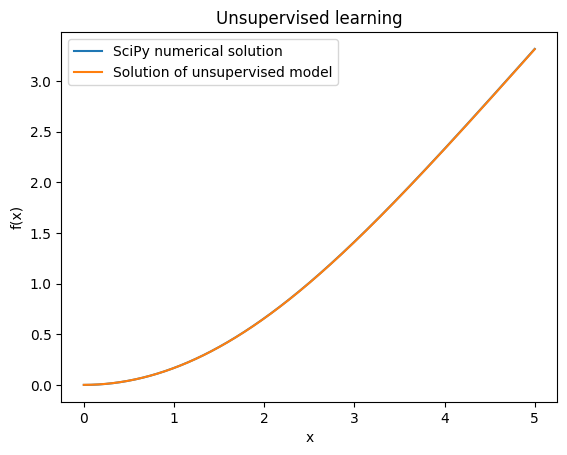

In [29]:
plt.plot(numericalSolution.x, numericalSolution.y[0], label='SciPy numerical solution')
plt.plot(eta, tf.reshape(networkUnsupervised(np.reshape(eta, (numPoints,1))), [numPoints]), label='Solution of unsupervised model')
plt.title('Unsupervised learning')
plt.ylabel('f(x)')
plt.xlabel('x')
plt.legend()
plt.show()

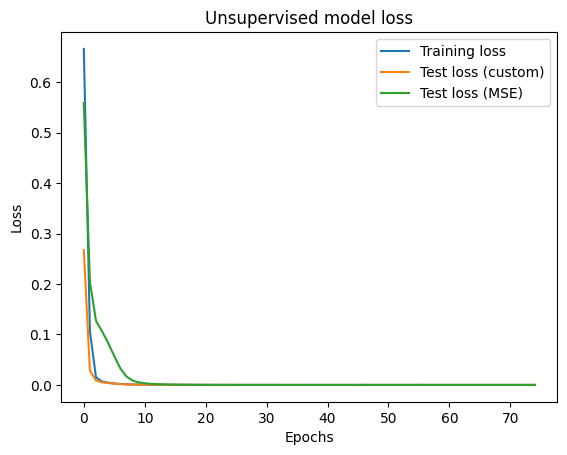

In [30]:
plt.plot(range(len(historyTrainingUnsupervised)),historyTrainingUnsupervised, label='Training loss')
plt.plot(range(len(historyTestNetworkUnsupervised)),historyTestNetworkUnsupervised, label='Test loss (custom)')
plt.plot(range(len(historyTestMSEUnsupervised)),historyTestMSEUnsupervised, label='Test loss (MSE)')
plt.title('Unsupervised model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

#### Quality of the model

To conclude our analysis of the model, we calculate the R^2 value to determine the quality of our model

In [31]:
R2(tf.reshape(networkUnsupervised(np.reshape(eta, (numPoints,1))), [np.size(eta)]), numericalSolution.y[0])

0.9999975181841056

The accordance between the values calculated using the PINN and the data (the numerical values reconstructed using the solve_bvp function) is extremely good, almost perfect




### Implementation from scratch of the algorithm (Supervised)

Now we will proceed to implement the PINN in the supervised case, meaning that in the loss function we will consider also the term related to the known data. Substantially, we are supposing that we do have empirical data that could help training the network

As known data we will use the values obtained from the numerical reconstruction of the solution through the solve_bvp function

**NOTE**: For the following implementation, reference was made to Refs. [2, 3, 4, 6, 7, 8, 9]

#### Importing the libraries

All the required libraries have already been imported when developing the unsupervised model

#### Setting the parameters

All the required parameters have already been set when developing the unsupervised model

#### Building the network

In [32]:
networkSupervised = Sequential()
networkSupervised.add(Dense(20, input_shape=(1,), activation="tanh", kernel_initializer='glorot_normal'))
networkSupervised.add(Dense(20, activation="tanh", kernel_initializer='glorot_normal'))
networkSupervised.add(Dense(1))

networkSupervised.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20)                40        
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


#### Definition of the routines to determine loss and gradient


In [33]:
#Residual of the  differential equation
def residual(f, dfdx, dfdxx, dfdxxx):
  return dfdxxx + (0.5*f*dfdxx)

In [34]:
#Function to calculate the derivatives of the model
def derivativeCalculation(model, x):
    #The function tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
      #The variable x is watched during tape to compute the derivative dfdx
      tape.watch(x)

      # Determine residual
      f = model(x)

      # Compute following derivatives
      dfdx = tape.gradient(f, x)
      dfdxx = tape.gradient(dfdx, x)
      dfdxxx = tape.gradient(dfdxx, x)

      del tape

    return [f, dfdx, dfdxx, dfdxxx]

In [35]:
#Function to calculate the residual of the model
def residualCalculation(model, x):
    f, dfdx, dfdxx, dfdxxx = derivativeCalculation(model, x)
    return residual(f, dfdx, dfdxx, dfdxxx)

One has now all the elements to calculate the custom loss function used in PINNs

In this case, along with the error derived from the residual of the differential equation and the one related to the boundary conditions, there will also be the loss term related to the the difference with known data, which in this case are given by the data calculated with the numerical solver in SciPy

In [36]:
def computeLossSupervised(model, x, xmin, xmax, yCorr):
  bl1 = tf.zeros(x.shape, dtype=DTYPE)
  bl2 = tf.zeros(x.shape, dtype=DTYPE)
  br = tf.ones(x.shape, dtype=DTYPE)

  xminVec = tf.zeros(x.shape, dtype=DTYPE)+xmin
  xmaxVec = tf.zeros(x.shape, dtype=DTYPE)+xmax

  leftBoundary = derivativeCalculation(model,xminVec) #Value of the model on the left boundary
  rightBoundary = derivativeCalculation(model,xmaxVec) #Value of the model on the right boundary

  #Loss with respect to the residual of the differential equation
  loss = tf.reduce_mean(tf.square(residualCalculation(model, x)))

  #Loss with respect to the boundary conditions
  loss += tf.reduce_mean(tf.square(leftBoundary[0]-bl1))
  loss += tf.reduce_mean(tf.square(leftBoundary[1]-bl2))
  loss += tf.reduce_mean(tf.square(rightBoundary[1]-br))

  #Loss with respect to the known data
  loss += tf.reduce_mean(tf.square(model(x) - yCorr))
  return loss

From the custom loss just defined, one can then define the function for computing the gradient of the model

In [37]:
def computeGradientSupervised(model, x, xmin, xmax, yCorr):
  with tf.GradientTape(persistent=True) as tape:
    # This tape is for derivatives with respect to trainable variables
    tape.watch(model.trainable_variables)
    loss = computeLossSupervised(model, x, xmin, xmax, yCorr)

    gradient = tape.gradient(loss, model.trainable_variables)

    del tape

  return loss, gradient

#### Definition of the training function

One needs then to define a custom training function using the custom gradient and loss functions defined above

In [38]:
#Learning rate
lr = 0.001

#Definition of the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

In [39]:
#Compiling the network
networkSupervised.compile(optimizer=optimizer)

In [40]:
#Function that does the train step
@tf.function
def trainStepSupervised(model, x, xmin, xmax, yCorr, optim):
  loss, gradient = computeGradientSupervised(model, x, xmin, xmax, yCorr)
  optim.apply_gradients(zip(gradient, model.trainable_variables))

  return loss

The weights and biases of the network are updated using the gradient descend algorithm

#### Training of the network

To be able to make the comparison between the two different implementation of the PINNs in the best way possible we w,ill train this network with the same parameters as in the unsupervised case. We will also use the same training and testing sets

In [41]:
#Training parameters
nEpochs = 100
nBatches = 100

#Array to store the history of values of loss values of the network
historyTrainingSupervised = [] #Array containing the history of the mean losses of any epoch of training
historyTestNetworkSupervised = [] #Array containing the history of the losses calculated on the test set at the end of every epoch of training
historyTestMSESupervised = [] #Array containing the history of the losses calculated as MSE with respect to the "empirical" data. They are calculated on the test set at the end of every epoch of training

#For a basic implementation of early stopping
patience = 3
wait = 0

In [42]:
tInit = time()

batchSize = round((numPoints - testSetSize)/nBatches)

for i in range(nEpochs):
  historyCompleteTrainingSupervised = []
  for j in range(nBatches):
    lossTrainingBatch = trainStepSupervised(networkSupervised, xTraining[j*batchSize:((j+1)*batchSize)-1,:], xmin, xmax, yTraining[j*batchSize:((j+1)*batchSize)-1,:], optimizer)

    #Append current loss to historyComplete
    historyCompleteTrainingSupervised.append(lossTrainingBatch)

  #Appends to history the mean loss of the current epoch
  historyTrainingSupervised.append(np.mean(historyCompleteTrainingSupervised))

  #Calculation of loss for test values
  testLossNetworkSupervised = computeLossSupervised(networkSupervised, xTest, xmin, xmax, yTest)
  historyTestNetworkSupervised.append(testLossNetworkSupervised)

  testLossMSESupervised = meanSquareError(networkSupervised(xTest), yTest)
  historyTestMSESupervised.append(testLossMSESupervised)

  #Output of the mean loss of the current epoch along with the loss associated to the test set calculated both with respecte to the custom lost function defined for the network and as mean square error
  print('Epoch {:03d}: Mean loss training = {:10.8e}, Test loss (network function) = {:10.8e}, Test loss (quadratic) = {:10.8e}'.format(i,np.mean(historyCompleteTrainingSupervised),testLossNetworkSupervised,testLossMSESupervised))

  #Simple implementation of early stopping
  #Stop the training if the loss on the test set does not decrease over a certain number of epochs
  if i > 1: #Check that we are not in the first iteration of the training process
    #If the loss does not decrease, the wait value is incresed by one
    if testLossNetworkSupervised > historyTestNetworkSupervised[-2]:
      wait += 1
    #If the loss decreases the wait variable is set again to zero and the network state is saved
    else:
      wait = 0
      networkSupervised.save("networkSupervised.keras")
  if wait >= patience: #If wait is equal to patience then execute early stopping
    print('--- Early stopping ---')
    #Loading the last model before the loss started to increase
    networkSupervised = load_model("networkSupervised.keras")
    break

#Print computation timelossTrainingBatch
tSupervisedPINN = time() - tInit
print('\nComputation time for supervised PINN: {} seconds'.format(tSupervisedPINN))

Epoch 000: Mean loss training = 2.04794422e+00, Test loss (network function) = 8.65882013e-01, Test loss (quadratic) = 2.06324199e-01
Epoch 001: Mean loss training = 5.92249970e-01, Test loss (network function) = 3.68749327e-01, Test loss (quadratic) = 6.08744789e-02
Epoch 002: Mean loss training = 2.39410492e-01, Test loss (network function) = 1.50456047e-01, Test loss (quadratic) = 9.66351837e-03
Epoch 003: Mean loss training = 1.16972425e-01, Test loss (network function) = 9.23705371e-02, Test loss (quadratic) = 1.98396685e-03
Epoch 004: Mean loss training = 7.85526447e-02, Test loss (network function) = 6.52210735e-02, Test loss (quadratic) = 9.87984883e-04
Epoch 005: Mean loss training = 5.65404588e-02, Test loss (network function) = 4.76593261e-02, Test loss (quadratic) = 6.18586332e-04
Epoch 006: Mean loss training = 4.18691985e-02, Test loss (network function) = 3.56865802e-02, Test loss (quadratic) = 4.37608255e-04
Epoch 007: Mean loss training = 3.16797422e-02, Test loss (net

**NOTE**: The warning on `GradientTape` was ignored, since we what to compute the higher order derivatives

#### Plotting the results

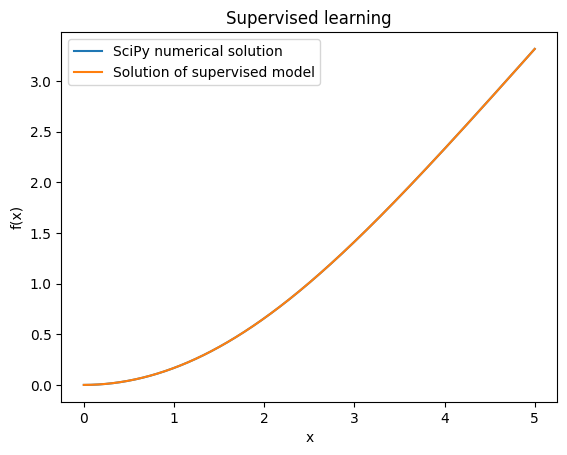

In [43]:
plt.plot(numericalSolution.x, numericalSolution.y[0], label='SciPy numerical solution')
plt.plot(eta, tf.reshape(networkSupervised(np.reshape(eta, (numPoints,1))), [numPoints]), label='Solution of supervised model')
plt.title('Supervised learning')
plt.ylabel('f(x)')
plt.xlabel('x')
plt.legend()
plt.show()

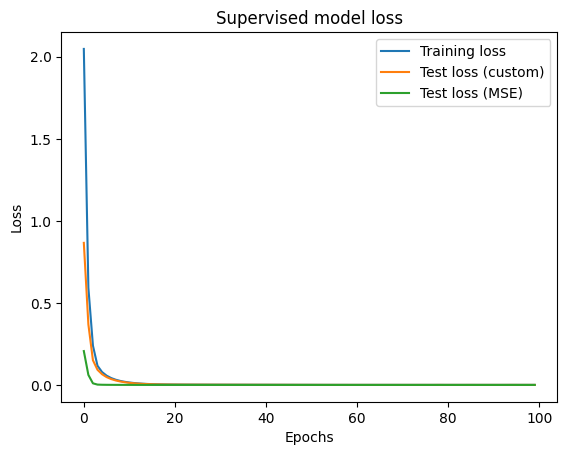

In [44]:
plt.plot(range(len(historyTrainingSupervised)),historyTrainingSupervised, label='Training loss')
plt.plot(range(len(historyTestNetworkSupervised)),historyTestNetworkSupervised, label='Test loss (custom)')
plt.plot(range(len(historyTestMSESupervised)),historyTestMSESupervised, label='Test loss (MSE)')
plt.title('Supervised model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

#### Quality of the model

To conclude our analysis of the model, we calculate the R^2 value to determine the quality of our model

In [45]:
R2(tf.reshape(networkSupervised(np.reshape(eta, (numPoints,1))), [np.size(eta)]), numericalSolution.y[0])

0.9999999321625505

The accordance between the values calculated using the PINN and the data (the numerical values reconstructed using the solve_bvp function) is extremely good, almost perfect

## Conclusions

### Comparing the SciPy algorith and the PINNs

As first concluding remark, we observe that the both PINNs were able to reconstruct numerically the solution of the Blausius equation as good as the traditional numerical metod implemented by the solve_bvp algorithm. This is proven by the value of the $R^2$ which is substantially equal to one in both cases

The main difference between the two methods is the execution time. Training the neural network, in this case, takes more time that executing the numerical solver

Therefore, we would say that in this case the classical method is still better than the one using PINN. However, it is still extremely interesting the fact that the neural network is able to reproduce so faithfully the results of the standar numerical methods just exploiting the knowledge about the differential equation, i.e. the underlying physics

### Comparison between the unsuperviesd and supervised PINNS

Both implementations have proved to be extremely effective in recostructing numerically the solution of the Blasisus equation, and, a part from the conceptual difference between the models, they are indistinguishable considering only the results they obtained

We can also check the combatibility between the two using the R^2 value

In [46]:
#Considering the unsupervised the tentative model and the supervised the known data
R2(tf.reshape(networkUnsupervised(np.reshape(eta, (numPoints,1))), [np.size(eta)]), tf.reshape(networkSupervised(np.reshape(eta, (numPoints,1))), [np.size(eta)]))

0.9999968972287403

In [47]:
#Considering the supervised the tentative model and the unsupervised the known data
R2(tf.reshape(networkSupervised(np.reshape(eta, (numPoints,1))), [np.size(eta)]), tf.reshape(networkUnsupervised(np.reshape(eta, (numPoints,1))), [np.size(eta)]))

0.9999969023152071

They are in perfect agreement

### Final plot

To conclude our project we make a final plot to visually compare the three different numerical reconstructions of the solution of the Blausius equation

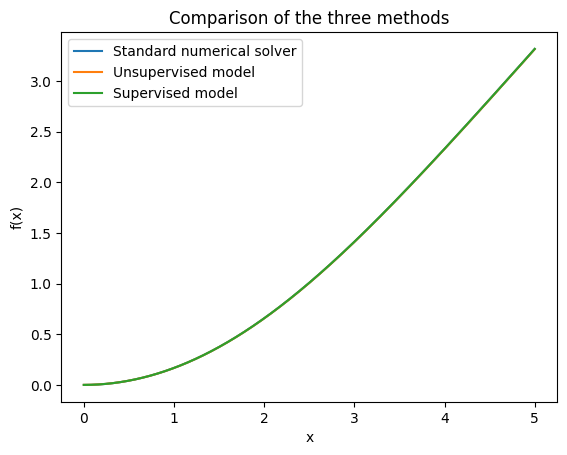

In [48]:
plt.plot(numericalSolution.x, numericalSolution.y[0],label='Standard numerical solver')
plt.plot(eta, networkUnsupervised(eta), label='Unsupervised model')
plt.plot(eta, networkSupervised(eta), label='Supervised model')
plt.title('Comparison of the three methods')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

As already highlighted, the three solutions are indistinguishable

### Final considerations

As final considerations we observe that the PINNs have proved to be an extremely effective method for the numerical reconstruction of the solution of differential equations. Both in case one has empirical data available with which to train the model, and when these are not available and one can rely only on the knowledge about the differential equation

Furthemore, we found quite impressive the fact that such small networks (1 x 20 x 20 x 1) where able to determine the solution with so little training and such high reliability
During our tests both models where able to consistently reach loss errors of approximately 1e-6 after a small number of training cycles

## References
[1] https://www.cfm.brown.edu/people/dobrush/am33/Mathematica/ch7/blasius.html

[2] Raissi M, Perdikaris P, Karniadakis GE (2017c) Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differen- tial Equations. URL: http://arxiv.org/abs/1711.10561

[3] Raissi M, Perdikaris P, Karniadakis GE (2017d) Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differen- tial Equations. URL: http://arxiv.org/abs/1711.10566

[4] Cuomo, S., Di Cola, V.S., Giampaolo, F. et al. Scientific Machine Learning Through Physics-Informed Neural Networks: Where we are and What's Next. J Sci Comput 92, 88 (2022). DOI: https://doi.org/10.1007/s10915-022-01939-z

[5] https://www.youtube.com/watch?v=vWcRuay1tt4

[6] Nascimento RG, Fricke K, Viana FA (2020) A tutorial on solving ordinary
differential equations using python and hybrid physics-informed neural net-
work. Engineering Applications of Artificial Intelligence 96:103,996. DOI: https://doi.org/10.1016/j.engappai.2020.103996, URL: https://www.sciencedirect.com/science/article/pii/S095219762030292X

[7] https://github.com/maziarraissi/PINNs/tree/master

[8] https://i-systems.github.io/tutorial/KSME/CAE/220520/01_PINN.html

[9] https://colab.research.google.com/drive/1BzjE3opm7nlyIQmaidxEhiaJ88rhnoiZ
